University of Zagreb<br/>
Faculty of Electrical Engineering and Computing<br/>
Department of Electronic Systems and Information Processing

Academic year 2023/2024

## **3rd laboratory exercise: Image restoration/Feature extraction**

*Digital Image Processing and Analysis*

Date: 2024-05-08

Please send any feedback (corrections, comments, suggestions etc.) regarding this document to ivana.matovinovic@fer.hr.

© University of Zagreb Faculty of Electrical Engineering and Computing, 2024.

Permission is granted to make and distribute copies of this instructions provided the copyright notice and this permission notice are preserved on all copies.

# Introduction

Instructions for laboratory exercises for the course *Digital Image Processing and Analysis* are prepared in a form of a <a href="https://jupyter.org/">Jupyter</a> notebooks.

All problems in prepared notebook are intended to be completed in Python using <a href="https://colab.research.google.com">Google Colaboratory</a> platform (Colab for short).

## How to Submit Your Laboratory Report

Simply write-in your code to all empty code cells and write in your answers to the text cells with questions.

Empty code cells contain the placeholder text `# Write-in your solution` while text cells where you have to write-in someting contain a bold uppercase text **WRITE YOUR ANSWER HERE**.

Once you have completed all problems save this notebook locally in a file named DIPA_LAB_X_NAME_SURNAME.ipynb,
where X is the exercise number, and submit it via Moodle under the appropriate upload section.

Your submissions will be first automatically re-evaluated which corresponds to selecting the *Runtime/Restart and run all* command in Colab. Therefore, it is strongly suggested that you run this command yourself before submitting your notebook. Another thing to do before submission is to clear all the cell outputs by selecting *Edit/Clear all outputs*. This will reduce the size of .ipynb files for upload.

## Student Information

Before proceeding double click on this text and then fill in your name:

Name: **NAME & SURNAME**

Student ID number (JMBAG): **0036XXXX**

## Suggested Reading

### General Reading

If you are not familiar with Python then start with a Python tutorial such as e.g. an official one available at <a href="https://docs.python.org/3/tutorial/">https://docs.python.org/3/tutorial/</a>.

Jupyter notebooks are relying on <a href="https://ipython.org/">IPython</a>, which is an interactive Python interpreter. Jupyter notebooks may be run locally or they may be conveniently executed remotely in Google Colaboratory via web browser.

Readers familiar with Matlab who have only basic knowledge of Python are strongly encouraged to read the document <a href="https://numpy.org/doc/stable/user/numpy-for-matlab-users.html">NumPy for Matlab users</a> before attempting to solve this laboratory exercise in Colab.

### Image Processing in Python

Some general image processing functions are available as a part of [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html). This basic functionality is extended by the [`scikit-image`](https://scikit-image.org/). We will also use [OpenCV](https://opencv.org/).

#Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Required Functions

To simplify the code in Python in this notebook we may deliberately import functions from <a href="https://www.scipy.org/">SciPy</a>, <a href="https://numpy.org/">NumPy</a> and <a href="https://matplotlib.org/">Matplotlib</a> directly into the global namespace so e.g. we can write `fft` instead of `scipy.fft.fft`.

Please keep in mind that such an approach may be tolerated for the purpose of a short laboratory exercise where risks of collisions and side effects are minimal. It is best always avoided in production code.

If you prefer to use namespaces then feel free to change the import statements to retain strict package separation, e.g. `import numpy as np`.

In [2]:
# Import packages
import cv2
import skimage.io

# To display images in browser
from google.colab.patches import cv2_imshow

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import *
from scipy.stats import *
from skimage.filters import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
import skimage.util
from mpl_toolkits import mplot3d

## Image loading

We will be using images from the [USC-SIPI database](http://sipi.usc.edu/database/) and additional images available on the [DIPA class webpage](https://www.fer.unizg.hr/en/course/dipaa/files#%23!p_rep_146016!_-204158-187329). To load any of these images, all we have to do is copy the URL of the image and write the following two lines of code.

In [3]:
url = "http://sipi.usc.edu/database/preview/misc/5.3.02.png"
img = skimage.io.imread(url, plugin = 'pil')

<ipython-input-3-d1b035592c21>:2: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  img = skimage.io.imread(url, plugin = 'pil')


## Image representations

[Grayscale](https://en.wikipedia.org/wiki/Grayscale) images are composed of pixels representing a grayscale value. In a computer a 2D grayscale image is represented as an $M \times N$ matrix of pixel values, which represent light intensity.

It takes several such matrices for colored images - one for each color channel. There are several color models used for color image representation. For instance, an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image has three channels (for red, green and blue color) so an $M \times N \times 3$ matrix is used.   Color images can be converted to grayscale images, usually by calculating a weighted sum of the channels. The [cv2.cvtColor()](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function is used to convert images from one color space to another.

These representations allow the use of common matrix operators for image processing and analysis.

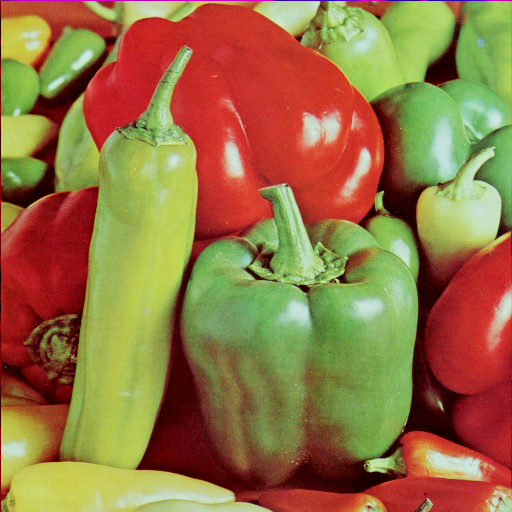

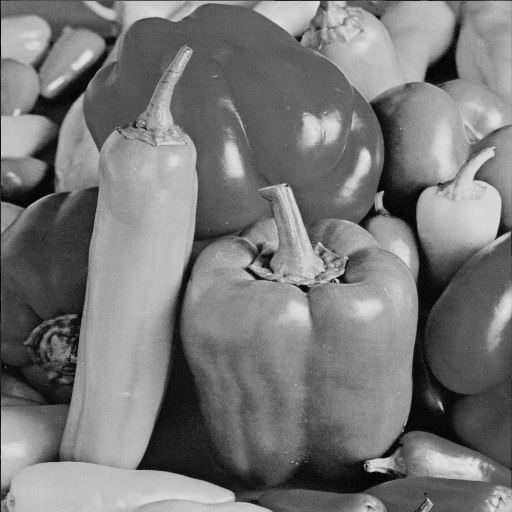

In [4]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
img = skimage.io.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # openCV uses BGR (blue, green, red) representation
cv2_imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img)

# 5.1 Image acquisition systems

Working with image acquisition systems (such as telescopes, cameras or medical imaging equipment), we
will encounter terms such as point spread function (PSF) (or sometimes blur kernel) and optical transfer
function (OTF). Point spread function is the system’s response to a point source of light, or in linear
systems terminology, it is the impulse response ($h$) of a linear system, since the point source of light can be
approximated by a delta function. Optical transfer function is the transfer function ($H$) of the acquisition system,
and is defined as the Fourier transform of the point spread function.

Let’s assume we’re observing a part of a night sky, which looks like the input image shown in the Fig.
5.1. Also, we assume that our telescope (image acquisition device) is completely described with its transfer
function, and that it does not add sensor noise or any other noise (such as atmospheric noise). If the point
spread function is known, then the acquired image will look as the output image in the Fig. 5.1. You can
notice that acquisition system changes the input image.

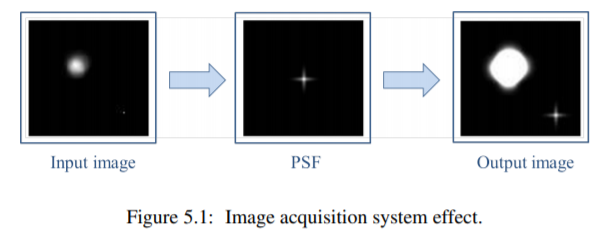

As we’ve learned before, the system’s response (output) is obtained by convolution of the input image $I$
with the imuplse response $h$ in the spatial domain, or by multiplication of the Fourier transform of the image
and the transfer function in the frequency domain.

If we only have the acquired image, and we want to restore the original (non-distorted) image
should look like, we can perform deconvolution, ie. we can define an inverse filter which removes the
image degradation effect of the acquisition system. Assuming that we know the OTF (or PSF) of the acquisition
system ($H(k,l)$), and if it is a spatially invariant system, we can define the inverse system as:
\begin{equation}
H_{i}(k, l)=\frac{1}{H(k, l)} \tag{5.1}
\end{equation}

Pseudo-inverse system is defined as:
 \begin{equation}
H_{p i}(k, l)=\left\{\begin{array}{ll}
\frac{1}{H(k, l)} & \forall |H(k, l)|>K \\
0 & \forall |H(k, l)| \leq K
\end{array}\right. \tag{5.2}
\end{equation}
where K is an arbitrarily chosen constant.

All details on these filters are explained further in this exercise.

## 5.1.1. Problems
1. Write a function which will take a degraded image and the PSF (modeled as an impulse response of finite dimensions) as inputs and calculate the original image using the inverse and pseudoinverse filter. (Note: Mind the difference between the linear and circular convolution, as explained in previous exercises.)

In [5]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift

def restore(imgD, psf, filter='inverse', K=1e-3):
    """
    Obnavlja sliku korištenjem inverznog ili pseudo-inverznog filtra.

    Args:
        imgD (ndarray): Degradirana slika (output iz akvizicijskog sustava).
        psf (ndarray): Point Spread Function (impulsni odziv sustava).
        filter (str): 'inverse' ili 'pseudoinverse'.
        K (float): Prag za pseudo-inverzni filter.

    Returns:
        imgR (ndarray): Restaurirana slika.
    """
    # Dimenzije i padding
    H, W = imgD.shape
    pad_psf = np.zeros_like(imgD)
    psfH, psfW = psf.shape
    pad_psf[:psfH, :psfW] = psf  # postavi PSF u gornji lijevi kut

    # Pomak PSF-a tako da bude centriran (kao kod cirkularne konvolucije)
    pad_psf = fftshift(pad_psf)

    # Fourierove transformacije slike i PSF-a
    G = fft2(imgD)
    H_f = fft2(pad_psf)

    # Inverzni filter
    if filter == 'inverse':
        # Dodavanje malog eps da se izbjegne dijeljenje s nulom
        eps = 1e-8
        H_f = np.where(np.abs(H_f) < eps, eps, H_f)
        F_hat = G / H_f

    # Pseudo-inverzni filter
    elif filter == 'pseudoinverse':
        mask = np.abs(H_f) > K
        H_pi = np.zeros_like(H_f, dtype=complex)
        H_pi[mask] = 1 / H_f[mask]
        F_hat = G * H_pi

    else:
        raise ValueError("filter must be 'inverse' or 'pseudoinverse'")

    # Inverzna Fourierova transformacija za dobivanje restaurirane slike
    imgR = np.real(ifft2(F_hat))

    return imgR

# 5.2  Image restoration
The goal of image restoration is to obtain an image as similar as possible to the original image, from the degraded image and the knowledge of a degradation model. Unlike image enhancement, which is an ill-posed problem, image restoration is a well defined problem. Degradation is usually modeled as
a complex system containing linear memory system and memoryless nonlinearity. Besides that, real-life systems always introduce the noise, which is usually modeled as additive noise. Neglecting the memoryless nonlinearity, the process of degradation and image restoration can be shown with the Fig. 5.2.




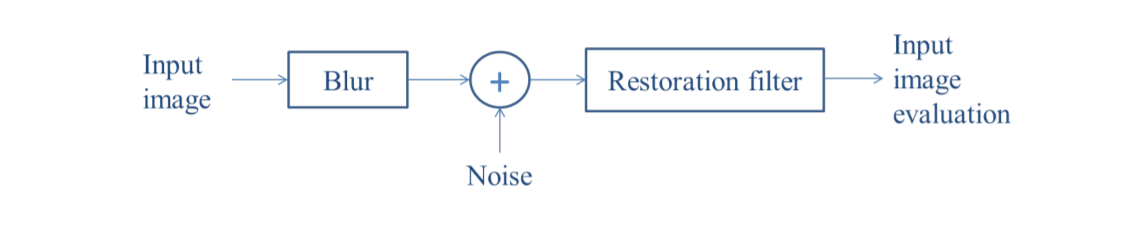

**Figure 5.2:** Scheme of the experiment. Blurring will be approximated with a linear system, and sensor noise
with the additive noise. Other noises are neglected. Restoration filter is used to try to obtain the original
(input) image. We emphasize that this is only an estimation, which is only as correct as the assumed model.


# 5.3 Modeling the degradation as a FIR filter
A linear system that represents the degradation function will be modeled as a [FIR (Finite Impulse Response) filter](https://en.wikipedia.org/wiki/Finite_impulse_response) which can be defined with its impulse response. For constructing different responses, we can use OpenCV and Numpy.

Since we will model all degradation as linear spatial invariant systems, the result obtained with this degradation can be obtained with linear convolution. If we want to apply several different degradation models (for example atmospheric blur and camera shift), we need to perform several consecutive convolutions. The response of such complex system can also be obtained by calculating linear convolution of each of the systems' responses.

In the following example, the weak atmospheric blur is modeled with a Gaussian-shaped filter, while the uniform camera shift in the horizontal and vertical direction is modeled with a 20 pixel shift per $x$ and $y$-axis simultaneously.

## Example:

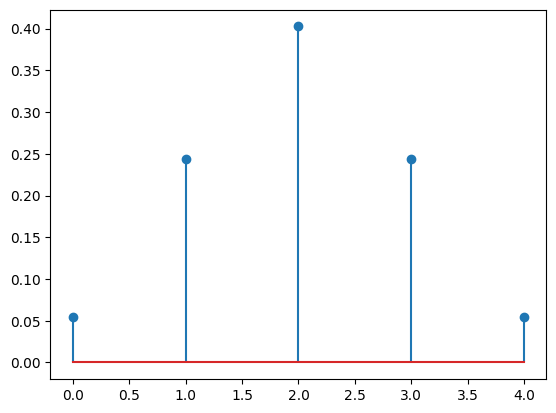

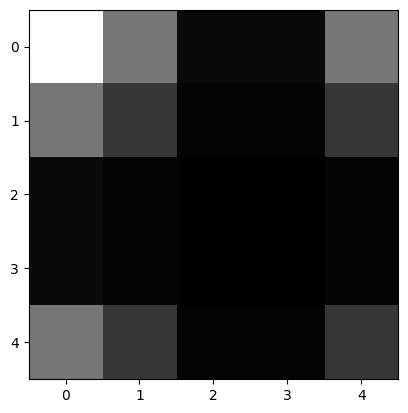

(24, 24)


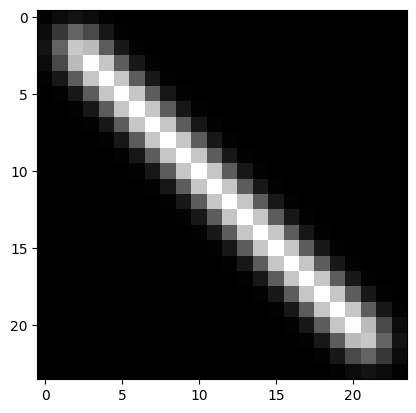

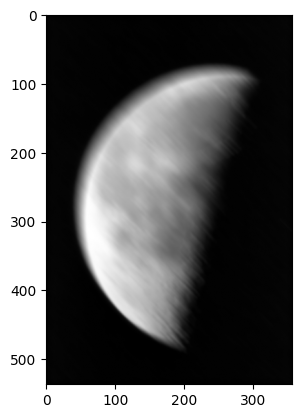

In [19]:
# DEFINITION OF THE DEGRADATION SYSTEM
h1=np.identity(20)/20                       # uniform shift
h2=cv2.getGaussianKernel(ksize=5, sigma=1)  # 1-D Gaussian kernel
plt.stem(h2)                                # display the 1-D Gaussian blurring imp. response in the spatial domain
plt.show()

h2_2D=np.outer(h2, h2)                      # 2-D Gaussian kernel
H2_2D=fft2(h2_2D)                           # frequency response of the Gaussian blurring
plt.imshow(np.abs(H2_2D), cmap='gray')      # display the 2-D Gaussian blurring transfer function (OTF)
plt.show()

h=convolve2d(h1, h2_2D)                     # the total blur is the convolution of the two impulse responses
print(h.shape)
plt.imshow(np.abs(h), cmap='gray')          # total impulse response in the spatial domain
plt.show()

# APPLICATION
img = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE)
imgB = convolve2d(img,h, mode='same')                    # apply the blur
plt.imshow(imgB, cmap='gray')               # display the degraded image

### **5.3.1 Problems**

1. Define the PSF and the OTF for typical blurs: 1) weak atmospheric blur - see *Image Restoration* lecture presentation, 2) vertical and horizontal
shift (for several pixels) simultaneously (a single function that covers both shifts).

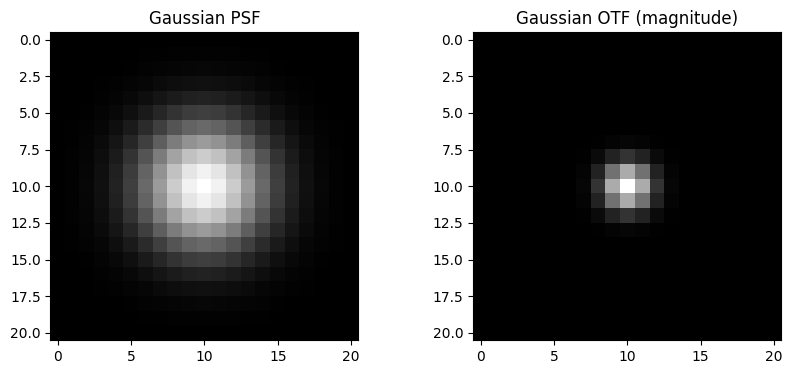

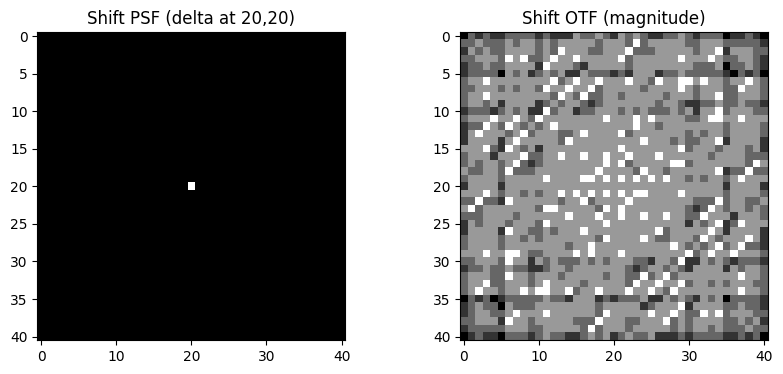

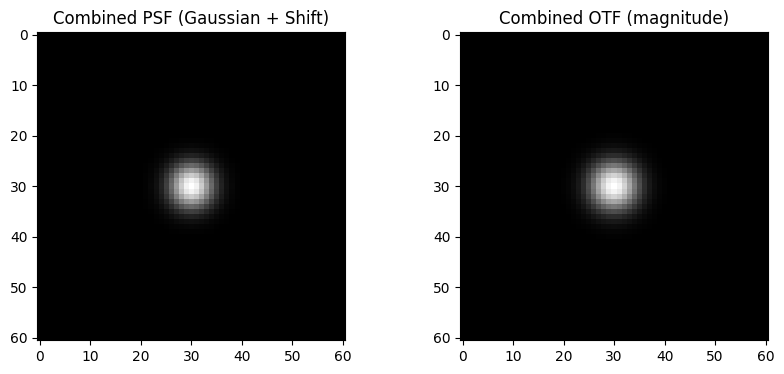

In [7]:
# Write-in your solution
import numpy as np
import cv2
from scipy.fft import fft2, fftshift
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Weak Atmospheric Blur (Gaussian PSF)
ksize = 21  # kernel size
sigma = 3   # standard deviation (blur strength)

# 1D Gaussian kernel
h1d = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)

# 2D Gaussian PSF
h_psf = np.outer(h1d, h1d)

# OTF: Fourier transform of PSF
H_otf = fft2(h_psf)

# Show PSF and OTF magnitude
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(h_psf, cmap='gray')
plt.title('Gaussian PSF')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fftshift(H_otf)), cmap='gray')
plt.title('Gaussian OTF (magnitude)')
plt.show()

# Vertical and Horizontal Shift (20 pixels)
shift_amount = 20
psf_shift = np.zeros((2*shift_amount+1, 2*shift_amount+1))
psf_shift[shift_amount, shift_amount] = 1  # delta shifted to (20, 20)

H_shift = fft2(psf_shift)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(psf_shift, cmap='gray')
plt.title('Shift PSF (delta at 20,20)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fftshift(H_shift)), cmap='gray')
plt.title('Shift OTF (magnitude)')
plt.show()

# Combined Blur and Shift
psf_combined = convolve2d(h_psf, psf_shift, mode='full')
H_combined = fft2(psf_combined)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(psf_combined, cmap='gray')
plt.title('Combined PSF (Gaussian + Shift)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fftshift(H_combined)), cmap='gray')
plt.title('Combined OTF (magnitude)')
plt.show()


2. Define the PSF and the OTF for a combination of the 2 mentioned blurs: weak atmospheric blur using α=0.5 +
vertical and horizontal shift for 10 pixels. The function obtained here will be used in the following
problems in this group.


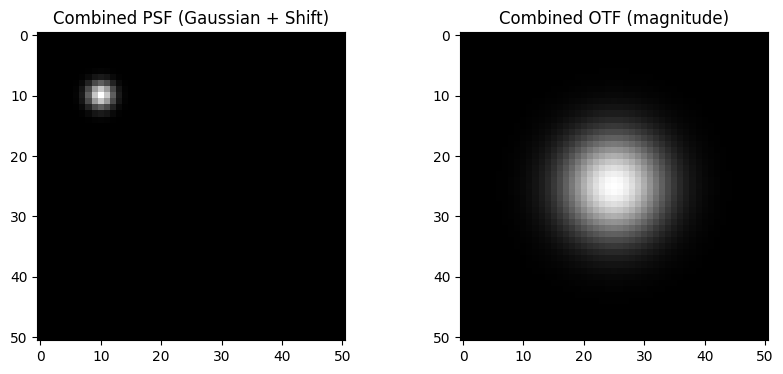

In [16]:
# Write-in your solution
alpha = 0.5                  # Gaussova alpha vrijednost
shift_amount = 10            # Pomak u pikselima
size = 51                    # Veličina kernela (mora biti dovoljno velika za Gauss i pomak)

# alpha u sigma: α^2 = 1 / (2 * σ^2) => σ = sqrt(1 / (2 * α^2))
sigma = np.sqrt(1 / (2 * alpha**2))
h1d = cv2.getGaussianKernel(ksize=size, sigma=sigma)
psf_gaussian = np.outer(h1d, h1d)

psf_shift = np.zeros((size, size))
psf_shift[shift_amount, shift_amount] = 1  # pomaknuta delta

psf_combined = convolve2d(psf_gaussian, psf_shift, mode='full')

center = psf_combined.shape[0] // 2
psf_combined_cropped = psf_combined[
    center - size // 2 : center + size // 2 + 1,
    center - size // 2 : center + size // 2 + 1
]
otf_combined = fft2(psf_combined_cropped)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(psf_combined_cropped, cmap='gray')
plt.title('Combined PSF (Gaussian + Shift)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fftshift(otf_combined)), cmap='gray')
plt.title('Combined OTF (magnitude)')
plt.show()

3. Apply the obtained PSF on the image salona.png.

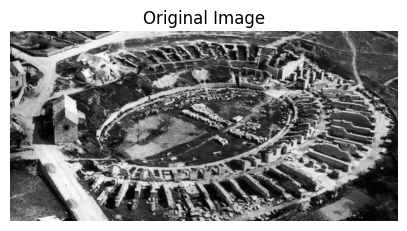

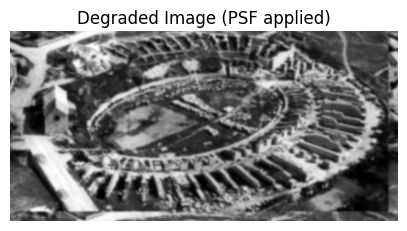

In [17]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/salona.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

alpha = 0.5
shift_amount = 10
size = 51

sigma = np.sqrt(1 / (2 * alpha**2))
h1d = cv2.getGaussianKernel(ksize=size, sigma=sigma)
psf_gaussian = np.outer(h1d, h1d)

psf_shift = np.zeros((size, size))
psf_shift[shift_amount, shift_amount] = 1

psf_combined = convolve2d(psf_gaussian, psf_shift, mode='full')

psf_combined /= np.sum(psf_combined)

img_degraded = convolve2d(img, psf_combined, mode='same', boundary='wrap')

plt.figure(figsize=(5,5))
plt.imshow(img_degraded, cmap='gray')
plt.title("Degraded Image (PSF applied)")
plt.axis('off')
plt.show()


4. Apply the obtained PSF on the image klis1.jpg for each of the channels separately. Display the obtained RGB image. Explain where does the black frame come from. What does its width depend on?

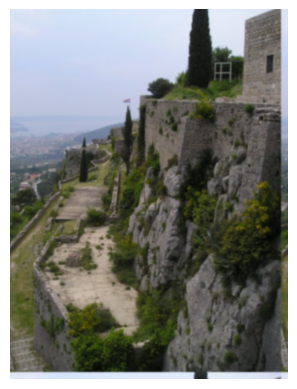

In [18]:
# Write-in your solution
img = cv2.imread('/content/drive/MyDrive/Images/klis1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

alpha = 0.5
shift_amount = 10
size = 51
sigma = np.sqrt(1 / (2 * alpha**2))
h1d = cv2.getGaussianKernel(ksize=size, sigma=sigma)
psf_gaussian = np.outer(h1d, h1d)

psf_shift = np.zeros((size, size))
psf_shift[shift_amount, shift_amount] = 1

psf_combined = convolve2d(psf_gaussian, psf_shift, mode='full')
psf_combined /= np.sum(psf_combined)

channels = []
for i in range(3):
    channel = img_rgb[:, :, i]
    degraded = convolve2d(channel, psf_combined, mode='same', boundary='wrap')
    degraded = np.clip(degraded, 0, 255).astype(np.uint8)
    channels.append(degraded)

img_degraded_rgb = np.stack(channels, axis=-1)

plt.imshow(img_degraded_rgb)
plt.axis('off')
plt.show()


The Gaussian PSF and its OTF illustrate how weak atmospheric blur primarily attenuates high-frequency components. When this PSF is combined with a 10-pixel shift, the resulting PSF becomes spatially displaced, and the OTF shows a phase shift in the frequency domain.

The black border visible in the blurred image of *klis1.jpg* is caused by the convolution operation near the image edges. As the filter kernel moves beyond the image bounds, missing pixel values are treated as zeros, which introduces edge artifacts. The width of this black frame depends on the PSF size, in this case, determined by the Gaussian kernel and the shift displacement.


# 5.4 Inverse filter
Inverse filter is defined with the Eq. 5.1.
Since this expression is literally calculation of an inverse, the obtained filter can be unstable. Besides
unstability, for most of the purposes this filter is not really efficient due to its great sensitivity to noise.
Because of the inevitable quantization to the definite number of discrete levels, even in the case of negligible
additive noise, the quantization is always present.
To get the error (due to the quantization or other degradations) we can calculate mean square error (MSE), as given in the following example.
Sometimes we also wish to know the power ratio of signal and noise, or even the power ratio of original signal and reconstructed signal. Note: Power ratios can also be calculated in decibels!


## Example:

In [21]:
imgR = restore(imgB, h)               #restoring the image using the function you wrote - problems 5.1.1

# MSE
img = img/255                         # switch to float and rescale to [0,1]
imgR = imgR/255                       # the second image as well
print(img.shape, imgR.shape)
err = np.mean((img-imgR)**2);         # calculate mean square error

# POWER RATIOS
imgP = np.abs(fft2(img))**2           # power spectrum of the original image
imgP_mean = np.mean(imgP)             # mean power of the original image
imgRP = np.abs(fft2(imgR))**2         # power spectrum of the restored image
imgRP_mean = np.mean(imgRP)           # mean power of the restored image
PR = imgP_mean/imgRP_mean             # original-to-restored image power ratio

print("err:", err, "\nimgP_mean:", imgP_mean, "\nimgRP_mean:", imgRP_mean, "\nPR:", PR)

# ADDITIVE NOISE
#noise = np.random.normal(0, 0.001, imgB.shape)
#imgBN = cv2.add(imgB, noise)                     # add the zero-mean, Gaussian noise with variance of 0.01
#imgBN[np.where(imgBN>1.0)]=1.0                   # adding noise can cause pixel values to be higher than 1, we need to correct that

(537, 358) (537, 358)
err: 126390.72651009535 
imgP_mean: 0.4039514017691419 
imgRP_mean: 24298111629.684544 
PR: 1.662480640164819e-11


Since it can be difficult to visualize the filter performance by comparing whole images before and after
filtering, we can compare only their columns or rows, which are 1D signals:

## Example:

(537, 358)


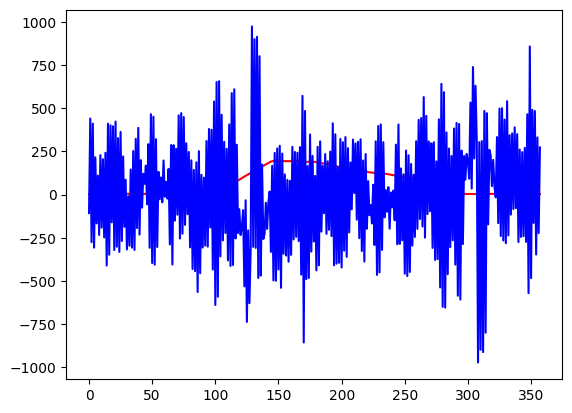

In [22]:
print(imgB.shape) # get the image size (height and width)
rowB = imgB[128,:] # get the 128th row of the degraded image
rowR = imgR[128,:]; # get the 128th row of the reconstructed image
plt.plot(rowB,'r') # show them simultaneously
plt.plot(rowR,'b')

### **5.4.1 Problems**
1. For the selected degradation (its PSF), display the result of inverse filtering for a case of: 1) degradation **without** additive noise and 2) degradation **with** additive noise for 2 images.

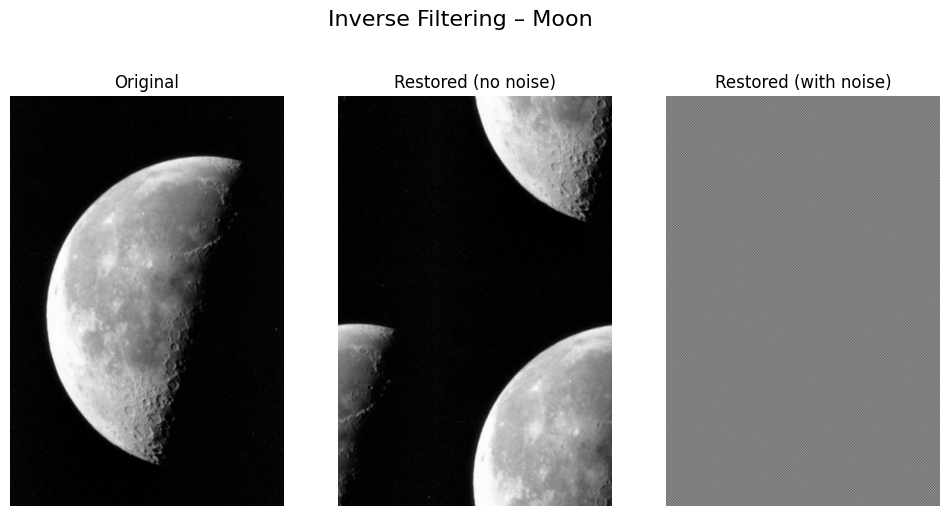

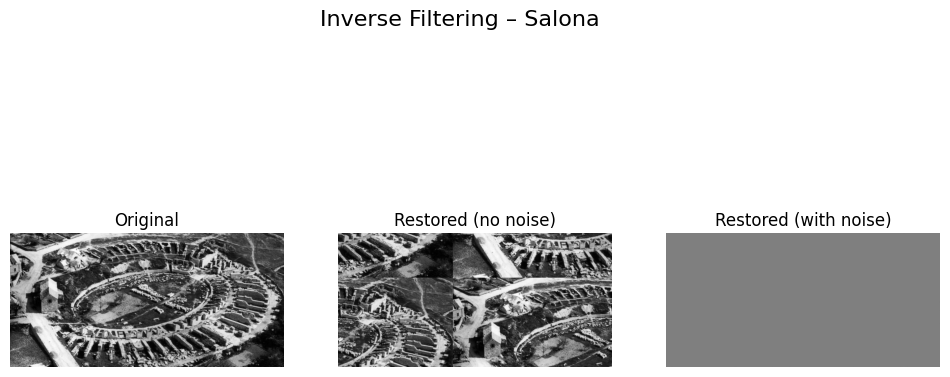

In [23]:
# Write-in your solution
def degrade(img, psf):
    return convolve2d(img, psf, mode='same', boundary='wrap')

def add_noise(img, std=0.01):
    noise = np.random.normal(0, std, img.shape)
    imgN = img + noise
    imgN[imgN > 1.0] = 1.0
    imgN[imgN < 0.0] = 0.0
    return imgN

# PSF (Gaussian + shift)
alpha = 0.5
shift_amount = 10
size = 51
sigma = np.sqrt(1 / (2 * alpha**2))
h1d = cv2.getGaussianKernel(ksize=size, sigma=sigma)
psf_gaussian = np.outer(h1d, h1d)
psf_shift = np.zeros((size, size))
psf_shift[shift_amount, shift_amount] = 1
psf_combined = convolve2d(psf_gaussian, psf_shift, mode='full')
psf_combined /= np.sum(psf_combined)

# Images
paths = ['/content/drive/MyDrive/Images/moon.tif', '/content/drive/MyDrive/Images/salona.png']
titles = ['Moon', 'Salona']

for idx, path in enumerate(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0

    imgB = degrade(img, psf_combined)
    imgBN = add_noise(imgB, std=0.01)

    imgR_clean = restore(imgB, psf_combined, filter='inverse')
    imgR_noisy = restore(imgBN, psf_combined, filter='inverse')

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Inverse Filtering – {titles[idx]}', fontsize=16)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(imgR_clean, cmap='gray')
    plt.title('Restored (no noise)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(imgR_noisy, cmap='gray')
    plt.title('Restored (with noise)')
    plt.axis('off')

    plt.show()


2. Calculate the MSE (between the reconstructed and original image) for both cases from the previous
problem.

In [24]:
# Write-in your solution
from skimage.metrics import mean_squared_error

paths = ['/content/drive/MyDrive/Images/moon.tif', '/content/drive/MyDrive/Images/salona.png']
titles = ['Moon', 'Salona']

for idx, path in enumerate(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0

    imgB = degrade(img, psf_combined)
    imgBN = add_noise(imgB, std=0.01)

    imgR_clean = restore(imgB, psf_combined, filter='inverse')
    imgR_noisy = restore(imgBN, psf_combined, filter='inverse')

    imgR_clean = imgR_clean[:img.shape[0], :img.shape[1]]
    imgR_noisy = imgR_noisy[:img.shape[0], :img.shape[1]]

    mse_clean = mean_squared_error(img, imgR_clean)
    mse_noisy = mean_squared_error(img, imgR_noisy)

    print(f"{titles[idx]}:")
    print("  MSE (no noise):", mse_clean)
    print("  MSE (with noise):", mse_noisy)

Moon:
  MSE (no noise): 0.24414441904043752
  MSE (with noise): 2227301670.3829436
Salona:
  MSE (no noise): 0.1443106804482072
  MSE (with noise): 2437844698.370325


3. Try the inverse filtering as previously for 2 cases, but with 8-bit quantization (with values 0 to 255) of the degraded image.
Display the results.

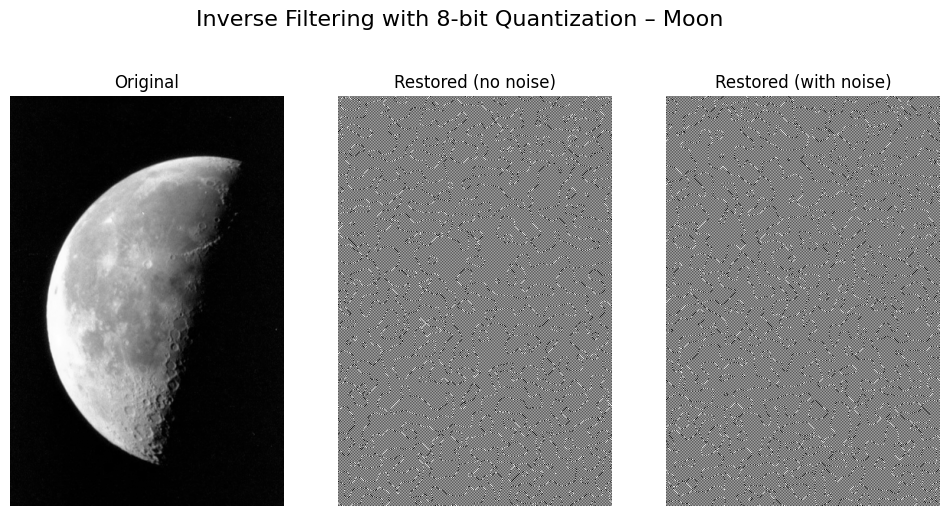

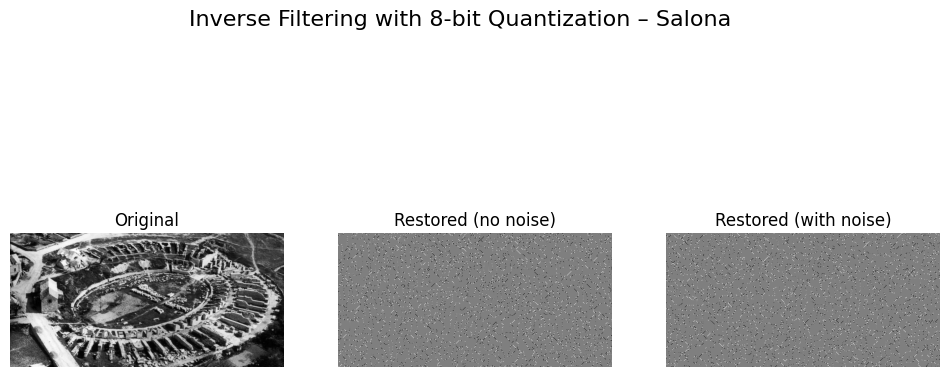

In [27]:
def degrade(img, psf):
    return convolve2d(img, psf, mode='same', boundary='wrap')

def add_noise(img, std=0.01):
    noise = np.random.normal(0, std, img.shape)
    imgN = img + noise
    imgN = np.clip(imgN, 0.0, 1.0)
    return imgN

# PSF (manji kernel za bolju restauraciju)
alpha = 0.5
shift_amount = 5
size = 21
sigma = np.sqrt(1 / (2 * alpha**2))
h1d = cv2.getGaussianKernel(ksize=size, sigma=sigma)
psf_gaussian = np.outer(h1d, h1d)
psf_shift = np.zeros((size, size))
psf_shift[shift_amount, shift_amount] = 1
psf_combined = convolve2d(psf_gaussian, psf_shift, mode='full')
psf_combined /= np.sum(psf_combined)

paths = ['/content/drive/MyDrive/Images/moon.tif', '/content/drive/MyDrive/Images/salona.png']
titles = ['Moon', 'Salona']

for idx, path in enumerate(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0

    imgB = degrade(img, psf_combined)
    imgBN = add_noise(imgB, std=0.01)

    imgB_q = (imgB * 255).astype(np.uint8).astype(np.float32) / 255.0
    imgBN_q = (imgBN * 255).astype(np.uint8).astype(np.float32) / 255.0

    imgR_clean = restore(imgB_q, psf_combined, filter='inverse')
    imgR_noisy = restore(imgBN_q, psf_combined, filter='inverse')

    imgR_clean = imgR_clean[:img.shape[0], :img.shape[1]]
    imgR_noisy = imgR_noisy[:img.shape[0], :img.shape[1]]

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Inverse Filtering with 8-bit Quantization – {titles[idx]}', fontsize=16)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(imgR_clean, cmap='gray', vmin=0, vmax=1)
    plt.title('Restored (no noise)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(imgR_noisy, cmap='gray', vmin=0, vmax=1)
    plt.title('Restored (with noise)')
    plt.axis('off')

    plt.show()


4. Calculate the MSE (between the reconstructed and original image) for both cases from the previous problem. How does the quantization influence the filtering result?

In [28]:
# Write-in your solution
paths = ['/content/drive/MyDrive/Images/moon.tif', '/content/drive/MyDrive/Images/salona.png']
titles = ['Moon', 'Salona']

for idx, path in enumerate(paths):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0

    imgB = degrade(img, psf_combined)
    imgBN = add_noise(imgB, std=0.01)

    imgB_q = (imgB * 255).astype(np.uint8).astype(np.float32) / 255.0
    imgBN_q = (imgBN * 255).astype(np.uint8).astype(np.float32) / 255.0

    imgR_clean = restore(imgB_q, psf_combined, filter='inverse')
    imgR_noisy = restore(imgBN_q, psf_combined, filter='inverse')

    imgR_clean = imgR_clean[:img.shape[0], :img.shape[1]]
    imgR_noisy = imgR_noisy[:img.shape[0], :img.shape[1]]

    mse_clean = mean_squared_error(img, imgR_clean)
    mse_noisy = mean_squared_error(img, imgR_noisy)

    print(f"{titles[idx]}:")
    print("  MSE (quantized, no noise):", mse_clean)
    print("  MSE (quantized, with noise):", mse_noisy)


Moon:
  MSE (quantized, no noise): 36144107.971672006
  MSE (quantized, with noise): 3454512168.600546
Salona:
  MSE (quantized, no noise): 22739767.69576197
  MSE (quantized, with noise): 1797919425.8451967


The results show that 8-bit quantization drastically degrades the performance of inverse filtering. Without quantization, inverse filtering can partially recover the original image, although it remains sensitive to noise. However, once the degraded image is quantized, the filtering process amplifies quantization artifacts and renders the reconstruction unusable, even without added noise. This is confirmed both visually and through extremely high MSE values in the quantized cases.

# 5.5 Pseudo-inverse filter
Pseudo-inverse filter is a stabilized version of the inverse filter. Sometimes a transfer function of a pseudoinverse system is additionally modified by multiplication with a transfer function of some low-pass filter, to
limit the response only to the low frequencies.


### **5.5.1 Problems**

1. For the selected PSF, calculate the result of pseudo-inverse filtering for a case of: 1) degradation without additive noise and 2) degradation with additive noise for the same 2 images as before. Display the results.


In [ ]:
# Write-in your solution

2. Calculate the MSE (between the reconstructed and original image) for both cases. Compare these results with the results obtained with inverse filtering.


In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

3. Try the pseudo-inverse filtering as previously for 2 cases, but with 8-bit quantization (with values 0 to 255) of the degraded image. Display the results.

In [ ]:
# Write-in your solution

4. Calculate the MSE (between the reconstructed and original image) for both cases from the previous problem. Compare these results with the results obtained with inverse filtering. How does the quantization influence the filtering result?

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 5.6. Wiener filter

Assuming that the degradation model is a wide sense stationary process and that the noise is uncorrelated
additive noise with a zero mean value, Wiener filter can be defined as:
\begin{equation}
H_{w}[k, l]=\frac{H^{*}[k, l]}{H^{*}[k, l] H[k, l]+\frac{S_{N N}[k, l]}{S_{X X}[k, l]}} \tag{5.3}
\end{equation}
where $H[k,l]$ is the OTF, $S_{NN}[k,l]$ is the power spectrum density of the noise and $S_{XX}[k,l]$ is the power spectrum density of the signal. The asterisk $^{*}$ denotes a complex conjugation. The complete expression can
be written in this form:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} S_{X X}[k, l]}{|H[k, l]|^{2} S_{X X}[k, l]+S_{NN}[k, l]} \tag{5.4}
\end{equation}
Which can be rewritten as:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} }{|H[k, l]|^{2} + \frac{1}{SNR[k, l]}} \tag{5.5}
\end{equation}
Here, we denote the signal-noise ratio function with SNR. This last expression is more convenient
for further consideration because from this expression we can see that Wiener filter can be obtained by
cascading inverse filter and a filter whose transfer function depends on the SNR on the particular frequency.
It means that for frequencies that are not affected by noise (1/SNR = 0), the transfer function will be equal
to 1 (it will be transferred without attenuation), while all the other frequencies will be attenuated with some
factor from the interval $[0,1 \rangle$.

The problem with determining the Wiener filter transform function is the estimation of the power spectrum density (ie. the autocorrelation functions of the signal and the noise) because usually we only have
access to the degraded image. Therefore, for the 1st approximation, we will assume the constant ratio K of
the power spectrum densities, making the transfer function look like this:
\begin{equation}
H_{w}[k, l]=\frac{1}{H[k, l]} \frac{|H[k, l]|^{2} }{|H[k, l]|^{2} + K} \tag{5.6}
\end{equation}

Here, parameter K can be approximated from the degraded image. Notice that for the small values of K,
Wiener filter is starting to look like inverse filter. An example of additive white noise removal with a use of
a Wiener filter is given with the following example. The [skimage.restoration.wiener](https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.wiener) function is used.

# Example

In [ ]:
img = cv2.imread('/content/drive/My Drive/Images/kljakovic2.png', cv2.IMREAD_GRAYSCALE)

img = img/255                                    # and of type float with values in the interval [0,1]
imgB = convolve2d(img,h)                         # blurring with atmospherical noise + camera shift

noise = np.random.normal(0, 0.001, imgB.shape)
imgBN = cv2.add(imgB, noise)                     # add the additive noise
imgBN[np.where(imgBN>1.0)]=1.0                   # adding noise can cause pixel values to be higher than 1, we need to correct that

plt.imshow(imgBN, cmap='gray')                   # display the noisy image
plt.show()

imgR=skimage.restoration.wiener(imgBN, psf=h, balance=0.0001)    # apply Wiener filter, note that balance=/=K
plt.imshow(imgR, cmap='gray')                    # display the restored image
plt.show()

## **5.6.1 Problems**
1. Using the code you wrote for pseudo-inverse filter, write the function to implement the Wiener filter described with the last equation. In the following problems, we will assume that we don’t know the values of the signal and noise power spectrum densities, and that we can model them with a constant K.


In [ ]:
# Write-in your solution

2.***  *Determine the result of the Wiener filtering in the case of a Gaussian noise with zero mean value. How can you estimate the parameter K?*



In [ ]:
# Write-in your solution (won't be graded)

**WRITE YOUR ANSWERS HERE**

3.*** *For the PSF used in previous groups of problems, determine the result of the Wiener filtering in a case
of additive noise .*


In [ ]:
# Write-in your solution (won't be graded)

4.*** *For the task 2 and 3 calculate the MSE between the reconstructed and original image.*

In [ ]:
# Write-in your solution (won't be graded)

5. *** *Compare the obtained results with the results obtained with inverse and pseudo-inverse filtering.*


**WRITE YOUR ANSWERS HERE** (won't be graded)

6. Calculate the SNR ratio before and after filtering.

In [ ]:
# Write-in your solution (won't be graded)

For estimation of the auto-correlation function, you are given the function *acf()*. For images
containing natural scenes, we can assume that there is correlation between the pixels up to 30 pixels distant,
so it is not necessary to calculate the full auto-correlation function (for all the pixel distances larger than
30).

In [ ]:
def acf(img, dx_max=30, dy_max=30):
    '''Calculates the autocorrelation function (ACF) for the image 'img'.
    'dx_max' and 'dy_max' determine the maximum shifts for which the ACF
    is calculated. The calculation is limited to shifts up to half of the
    image because of unwanted marginal effects.'''
    img = np.array(img, dtype='float')
    n, m = img.shape
    if dx_max > n//2:
        dx_max = n//2
    if dy_max > m//2:
        dy_max = m//2

    dx_max+=1                           # add one for shift=0
    dy_max+=1
    rxx = np.zeros((dx_max, dy_max))

    # calculating ACF for desired positive shifts dx and dy
    for dx in range(dx_max):
        for dy in range(dy_max):
            rxx[dx,dy] = correlate2d(img[:-dx_max,:-dy_max], img[dx:-dx_max+dx,dy:-dy_max+dy], mode='valid')
            # correlation of two matrices of same dimensions using 'valid' mode gives only one value, a scalar

    # the ACF is symmetrical so we can just fill in the results for negative shift values
    rxx = np.hstack((np.fliplr(rxx[:,1:]), rxx))
    rxx = np.vstack((np.flipud(rxx[1:,:]), rxx))
    return rxx


# Example

In [ ]:
img = cv2.imread('/content/drive/My Drive/Images/kljakovic3.png', cv2.IMREAD_GRAYSCALE)

rxx = acf(img)                                   # calculate auto-corr. fcn for the distances
                                                 # up to 30 pixel shifts is x and y-direction
print(rxx.shape)
plt.imshow(rxx, cmap='gray')                     # display the calculated auto-corr. fcn
print(rxx[30,30])

## **5.6.2 Problems**
*1. Degrade the image with the Gaussian noise with a zero mean value.* *italicized text*


In [ ]:
# Write-in your solution (won't be graded)

*2. Calculate and display the auto-correlation function $R_{XX}$ estimated from the degraded image.*


In [ ]:
# Write-in your solution (won't be graded)

*3. Calculate and display the auto-correlation function $R_{NN}$ of the noise.*


In [ ]:
# Write-in your solution (won't be graded)

*4. Determine the result of the Wiener filtering, with the known auto-correlation functions of the signal
and the noise (ie. with the known power density functions of the signal and the noise). *Hint:* Power density function is the Fourier transform of the auto-correlation. Power density should be used as the Wiener filter equations 5.3-5.6 suggest. *


In [ ]:
# Write-in your solution (won't be graded)

*5. Compare the auto-correlation $R_{XX}$ calculated on the degraded and the restored image.*


**WRITE YOUR ANSWERS HERE** (won't be graded)

*6. Repeat these problems for an image degraded with the PSF defined in previous problems and the
additive Gaussian noise. Compare and comment on the results.*


In [ ]:
# Write-in your solution (won't be graded)

**WRITE YOUR ANSWERS HERE** (won't be graded)

## Useful functions

First, let's define some function that will be useful throughout the exercise.

In [ ]:
def im2row(A, BSZ):
    windows = skimage.util.view_as_windows(A, BSZ)
    return windows.reshape(-1, BSZ[0] * BSZ[1])

In [ ]:
def getPadRanges(nhood):
  l = []
  for x in nhood:
    l.append((x // 2, x // 2 - 1))

  return tuple(l)

In [ ]:
def imshift(img, shift):
  dy, dx = shift

  img1 = img[dx:, dy:]   # crop the images to obtain
  img2 = img[:-dx, :-dy] # the (x, y) shift between them

  return (img1, img2)

In [ ]:
def rowfilt(img, nhood, func):
  #Pad the image to not lose image resolution
  #after applying the function func
  img2 = np.pad(img,
                getPadRanges(nhood),
                mode = 'constant')

  #Converts each nhood window of img
  #into a row of the new matrix rows
  rows = im2row(img2, nhood)

  #Apply function func on each row of rows
  newrows = np.apply_along_axis(func, 1, rows)

  #Return the result in the form of an image
  return np.reshape(newrows, img.shape)

In [ ]:
def nlfiltShift(img, nhood, func, shift = (1, 1)):
  #Pad the image to not lose image resolution
  #after applying the function func
  img2 = np.pad(img,
                getPadRanges(nhood),
                mode = 'constant')

  #Lists each nhood window of img
  blocks = skimage.util.view_as_windows(img2, nhood)

  bshape = blocks.shape
  blocks = np.reshape(blocks, (bshape[0] * bshape[1],
                               bshape[2],
                               bshape[3]))

  #Apply function func on each block/window
  newblocks = np.array(list(map(lambda block: func(np.array(block), shift),
                                blocks.tolist())))

  #Return the result in the form of an image
  return np.reshape(newblocks, img.shape)

In [ ]:
def absolute(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                             img2.flatten(),
                                             bins = BIN_SIZE,
                                             range = ((0, 256),
                                                      (0, 256)))

  p = histogram / np.sum(histogram)

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += abs(i - j) * p[i, j]

  return result

In [ ]:
def covariance(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                             img2.flatten(),
                                             bins = BIN_SIZE,
                                             range = ((0, 256),
                                                      (0, 256)))

  p = histogram / np.sum(histogram)

  a1 = (BIN_SIZE - 1) / 2.0
  a2 = (BIN_SIZE - 1) / 2.0

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += (i - a1) * (j - a2) * p[i, j]

  return result

In [ ]:
def energy(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                             img2.flatten(),
                                             bins = BIN_SIZE,
                                             range = ((0, 256),
                                                      (0, 256)))

  p = histogram / np.sum(histogram)

  return np.sum(p * p)

In [ ]:
def entropy(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                             img2.flatten(),
                                             bins = BIN_SIZE,
                                             range = ((0, 256),
                                                      (0, 256)))

  p = histogram / np.sum(histogram)
  log_p = np.log2(p)

  log_p[np.where(np.isneginf(log_p))] = 0

  return -np.sum(p * log_p)

In [ ]:
def inertia(block, p, BIN_SIZE = 16):
  block = block.astype('float32') #Convert to decimal
  img1, img2 = imshift(block, p) #Get shifted subimages

  #2nd order histogram
  histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                             img2.flatten(),
                                             bins = BIN_SIZE,
                                             range = ((0, 256),
                                                      (0, 256)))

  p = histogram / np.sum(histogram)

  result = 0
  for i in range(BIN_SIZE):
    for j in range(BIN_SIZE):
      result += ((i - j) ** 2) * p[i, j]

  return result

# 6.1 Image features

## 6.1.1 Spatial features

Features can be differentiated based on the domain of their definition, for example there are spatial, temporal, frequency features, etc.

Since the word ”image” usually refers to an image in 2D space, for most of applications we use spatial features. Based on these features the computer can analyze, describe and interpret the image content. Therefore, image feature retrieval is the first step for computational image analysis.

## 6.1.2 Amplitude features

For each pixel in an image, amplitude features are defined as some parameters calculated from neighborhood pixel intensities.

In the beginning of the exercise, the function *rowfilt()* has been defined. Its usage is shown in the example below.

## Example:

In [ ]:
testpat1 = cv2.imread('/content/drive/My Drive/Images/testpat1.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

img = rowfilt(testpat1, (32, 32), np.average); #Process the image

#Display the image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')

### **6.1.3 Problems**

1. Select an image with smaller dimensions (such as 256×256), or crop a larger image to this size. For the selected image calculate several amplitude features by using various numpy feature extraction functions, e.g. [numpy.max()](https://numpy.org/doc/stable/reference/generated/numpy.max.html), [numpy.min()](https://numpy.org/doc/stable/reference/generated/numpy.min.html), [numpy.average()](https://numpy.org/doc/stable/reference/generated/numpy.average.html), [numpy.std()](https://numpy.org/doc/stable/reference/generated/numpy.std.html) and the function *rowfilt()*.

In [ ]:
# Write-in your solution

2. How do the results depend on the selected block size?

**WRITE YOUR ANSWERS HERE**

# 6.2 First order histogram features

Pixel values within an image can be interpreted as the realizations of a random variable.

In that case, the first-order histogram represents an estimation of the probability density function (PDF) for the given random variable. Based on this estimation, we can determine various statistical properties (features) such as moments and central moments of the PDF.

Besides moments, we find entropy and energy of the
histogram interesting in image processing as well.

To do this, we first need to calculate the first order histogram, which can be done by calling the function [numpy.histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html).

## Example:

In [ ]:
testpat1 = cv2.imread('/content/drive/My Drive/Images/testpat1.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

# Calculate and plot the first order histogram
histogram, bin_edges = np.histogram(testpat1.flatten(),
                                    bins = 256,
                                    range = (0, 256))

plt.figure()
plt.title("First order histogram")
plt.xlim((0, 256))
plt.plot(bin_edges[:-1], histogram)
plt.show()

### **6.2.1 Problems**

1. Write the functions for calculating entropy and energy in order to be used with the function *rowfilt()*. Mathematical expressions for calculating these features are given in the lecture slides.

In [ ]:
# Write-in your solution

2. Select an image with smaller dimensions (such as 256×256), or crop a larger image to this size. For the selected image calculate the $1^{st}$ order histogram features (entropy and energy) on the block/window of size 5×5 by using the funciton *rowfilt()*. Display the results and comment on them.

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 6.3 Second order histogram features

As described earlier, pixel intensity values can be interpreted as the realizations of a random variable. In that case, the first order histogram represents the estimation of the probability density function (PDF) of the given random variable.

Instead of observing a single pixel, we can observe a pair of pixels, whose mutual position is defined by a specific spatial relation. In that case, we can observe two random variables corresponding to the pair of pixel values.  In that case, their joint (second-order) probability density function can be estimated using the second-order histogram with the help of the function [numpy.histogram2d()](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html).

## Example:

In [ ]:
testpat1 = cv2.imread('/content/drive/My Drive/Images/testpat1.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

testpat1 = testpat1.astype('float32') # Convert to decimal format

# Calculate and plot the second order histogram for the
# (2, 3) shifted subimages
img1, img2 = imshift(testpat1, (2, 3))

histogram, xedges, yedges = np.histogram2d(img1.flatten(),
                                           img2.flatten(),
                                           bins = 16,
                                           range = ((0, 256),
                                                    (0, 256)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.title.set_text("Second order histogram")

## Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

## Construct arrays with the dimensions for the bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = histogram.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

### **6.3.1 Problems**


1. Read the image 4.2.07.tiff from the USC-SIPI database. Calculate and display the $2^{nd}$ order histograms for shifts of (1, 1) and (5, 5).

In [ ]:
# Write-in your solution

2. Why are the results grouped around a diagonal?

**WRITE YOUR ANSWERS HERE**

3. Why are they more dispersed in the second case?

**WRITE YOUR ANSWERS HERE**

4. Read the image saturn.tif and calculate the $2^{nd}$ order histograms
for several shifts of your choice.
Display the results and comment on them.

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 6.4 Edge detection

Edge detection is one of the most important tasks in image processing since the edges define borders of objects. Therefore we can use them to segment, register and/or identify objects in the image.

Since the edges in an image are characterized by a sudden change of the amplitude values of the pixels, we can employ the gradient estimation methods for their detection.

## 6.4.1 Sobel and Prewitt operator

Gradient-based methods estimate the image gradient in two orthogonal directions, e.g. x and y. For a given location in the image, these two gradient values define the gradient vector, i.e. its direction and its norm. We can use any vector norm according to our preference. For example, if we want to use the Euclidean norm we can calculate it as the square root of the sum of the squared gradient vector components, as shown in the Fig. 6.1.

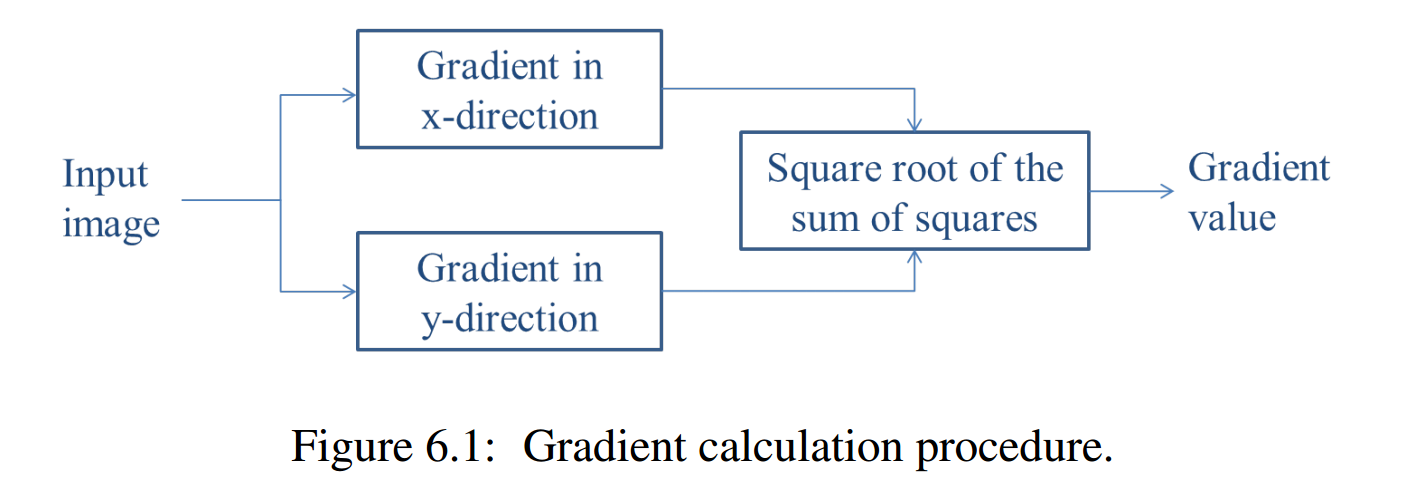

Applying the Sobel and the Prewitt operator on an image can be done with the functions [skimage.filters.sobel()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel) and [skimage.filters.prewitt()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.prewitt), respectively.

## Example:

In [ ]:
moon = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

sobel_gradient = sobel(moon) #Apply the Sobel operator

plt.figure(figsize=(8,8))
plt.imshow(sobel_gradient, cmap='gray') #Visualizing the gradients

### **6.4.2 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply the Sobel and the Prewitt operator to this image to estimate its edges. Display the results and comment on them.

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

## 6.4.3 Compass operators for edge detection

Gradient-based methods estimate the gradient in two directions. Compass operators detect edges oriented at a certain angle. Examples of the masks (of size 3 × 3) for angles 0, 45 and 90 degrees can be generated as shown below.

## Example:

In [ ]:
#0 degree angle mask
h0 = np.array([[1, 1, 1],
               [0, 0, 0],
               [-1, -1, -1]])

#45 degree angle mask
h45 = np.array([[1, 1, 0],
                [1, 0, -1],
                [0, -1, -1]])

#90 degree angle mask
h90 = np.array([[1, 0, -1],
                [1, 0, -1],
                [1, 0, -1]])

Convolution of an image with the selected compass operator results in an image with emphasized edges at the selected angle.

### **6.4.4 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply several compass operators on this
image (for different directions).

*Hint: try using the [scipy.signal.convolve2d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) function*

In [ ]:
# Write-in your solution

2. What happens with the edges positioned in the direction that does not correspond to the specific
operator?

**WRITE YOUR ANSWERS HERE**

3. Calculate and display the frequency characteristics for the selected compass operators. (This can be
done with the function [scipy.fft.fft2()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft2.html) as described in the Exercise 3.)

In [ ]:
# Write-in your solution

4. Why is their resolution so small?

**WRITE YOUR ANSWERS HERE**

## 6.4.5 Laplacian operator for edge detection

Gradient masks give the best result in cases when there are sudden edges, ie. large change in the pixel intensity values. For the ”softer” edges, methods using estimations based on the second derivatives give better results.

An example of such estimation is the Laplacian operator. Applying the Laplacian operator on an image can be simply done by using the function [skimage.filters.laplace()](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.laplace).

## Example:

In [ ]:
moon = cv2.imread('/content/drive/My Drive/Images/moon.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

lap_gradient = laplace(moon) #Apply the Sobel operator

plt.figure(figsize=(8,8))
plt.imshow(lap_gradient, cmap='gray') #Visualizing the gradients

### **6.4.6 Problems**

1. Read the image 4.2.07.tiff from the USC-SIPI database. Apply the Laplacian operator approximation on this image. Display
the results and comment on them.

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

# 6.5 Texture features

Textures are present in almost every image. In this part of the exercise, we will use the $2^{nd}$ order histogram features to represent texture features. For that purpose, we will use the function *rowfilter()* to calculate each feature on the window (of the defined size) in the input image.

## Example:

In [ ]:
testpat1 = cv2.imread('/content/drive/My Drive/Images/testpat1.tif', cv2.IMREAD_GRAYSCALE) #Read the grayscale image

testpat1 = testpat1.astype('float32') #Convert to decimal format

img = nlfiltShift(testpat1,
                  (16, 16),
                  inertia,
                  shift = (2, 2)); #Process the image

#Display the image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')

You can notice that for calculating the second order histogram, we need to define the relative spatial relation between the two pixels, i.e. a shift vector, p = (dy, dx), which corresponds to the shift between the two pixels under observation.

This can be a problem since even for small neighborhoods the number of possibilities is very large.

Therefore, to reduce the calculation time, select the images with smaller dimensiona and choose a smaller neighborhood size. Also, have in mind that the shift vector p has to be smaller than the neighborhood size.

### **6.5.1 Problems**

1. Read the image texture.png, which contains 5 different areas: 3 textures and 2 plain areas. Calculate various features with the functions defined in the beginning of the exercise, i.e. *absolute()*, *inertia()*, *energy()*, *entropy()*, and *covariance()*.
For each of them try each of these shifts: (2, 2), (3, 3) and (3, 5). Define the window size as (12, 12).
Display the results and comment on them.

In [ ]:
# Write-in your solution

**WRITE YOUR ANSWERS HERE**

2. Select few images that display different textures (you can crop the image to work with images of
smaller dimensions). Select a single feature and calculate it for each of the chosen images.

In [ ]:
# Write-in your solution

3. Do the features exhibit a sufficient difference to use them for the texture classification?

**WRITE YOUR ANSWERS HERE**

4. Which feature seems the best to perform the classification of the textures in the image?

**WRITE YOUR ANSWERS HERE**